<a href="https://colab.research.google.com/github/Pomtomato/Colab-Notebooks/blob/main/Plate_PINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18171 sha256=f1541a87f5fd61e6c430758f6b2579b9eb53ad81179a6e1a8bc13e34a59c671b
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


In [ ]:
#@title dependencies
import torch
import torch.autograd as autograd
from torch import tensor
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs
import scipy.io

torch.set_default_dtype(torch.float)

torch.manual_seed(1234)
np.random.seed(1234)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

if device == 'cuda':
  print(torch.cuda.get_device_name(0))

cpu


In [ ]:
#@title plot3d
def plot3D(x,y,w):
  x_plot = x
  y_plot = y
  X, Y = torch.meshgrid(x_plot, y_plot)
  W_xy = w
  fig, ax = plt.subplots(1,1)
  cp = ax.contourf(X,Y,W_xy,20,cmap='rainbow')
  fig.colorbar(cp)
  ax.set_title('W(x,y)')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(X.numpy(), Y.numpy(), W_xy.numpy(), cmap='rainbow')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('W(x,y)')
  plt.show()

In [ ]:
#@title plot3D_Matrix
def plot3D_Matrix(x,t,y):
  X, T = x, t
  F_xt = y
  fig, ax = plt.subplots(1,1)
  cp = ax.contourf(T,X,F_xt,20,cmap='rainbow')
  fig.colorbar(cp)
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(), cmap='rainbow')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('F(x,t)')
  plt.show()

In [ ]:
#@title exact
def real_solution(x,y,n,m,q,D):
  fFS = torch.zeros_like(x)
  a, b = x[-1,-1].item(), y[-1,-1].item()

  for i in range(1,n+1):
    for j in range(1,m+1):
      Wij = ((16*q0)/(D *(torch.pi)**6 *j *i *(i/a)**2 *(j/b)**2)) * torch.sin(i*torch.pi*x/a) * torch.sin(j*torch.pi*y/b)

      fFS = fFS + Wij
  return fFS

/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


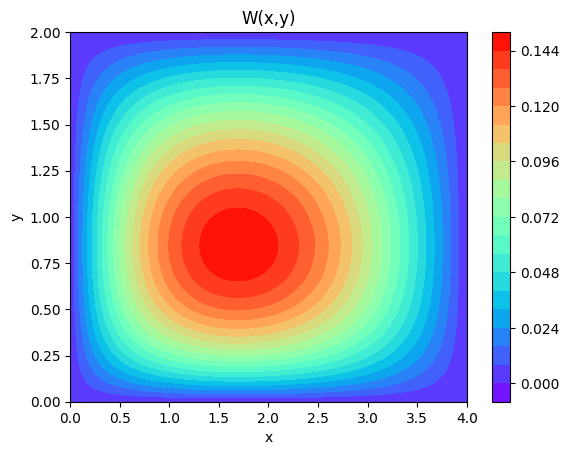

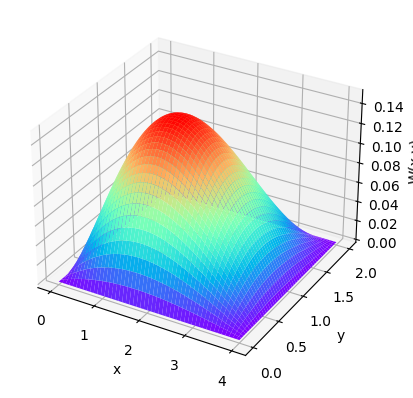

In [ ]:
n=20
m=20
x = torch.linspace(0,4,200) # (a x b x h) = (400 x 200 x 10) = (length, width, height)
y = torch.linspace(0,2,200) # (a x b x h) = (400 x 200 x 10)
X,Y = torch.meshgrid(x,y, indexing='xy')
D = 7000 # let flexural rigidity
q0 = 1000 # let constant loading q(x,y) = q0


w_real = real_solution(X,Y,n,m,q0,D)
plot3D(x,y,w_real)

In [ ]:
w_real.shape, X.shape, Y.shape, x.shape, y.shape

(torch.Size([200, 200]),
 torch.Size([200, 200]),
 torch.Size([200, 200]),
 torch.Size([200]),
 torch.Size([200]))

In [ ]:
#@title simple NN
class FCN(nn.Module):
  def __init__(self, layers):
    super().__init__()
    self.activation = nn.Tanh()
    #self.loss_function = nn.MSELoss(reduction='mean')
    self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])

    for i in range(len(layers)-1):
      nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
      nn.init.zeros_(self.linears[i].bias.data)

  def forward(self,x):
    if torch.is_tensor(x) != True:
      x = torch.from_numpy(x)
    a = x.float()
    for i in range(len(layers)-2):
      z = self.linears[i](a)
      a = self.activation(z)
    a = self.linears[-1](a)
    return a

In [ ]:
#@title data prep
#test points
xy_test = torch.cat((X.flatten()[:,None], Y.flatten()[:,None]), dim=1)
w_test = w_real.flatten()[:,None]
print(f"test_points: {xy_test.shape},\nexact_values:{w_test.shape}")

lb = xy_test[0]
ub = xy_test[-1]
print(f"lb: {lb},\nub: {ub}")

#boundary points

left_X0 = torch.cat((X[:,0][:,None],Y[:,0][:,None]), dim=1)
right_Xa = torch.cat((X[:,-1][:,None],Y[:,-1][:,None]), dim=1)
bot_Y0 = torch.cat((X[0,:][:,None], Y[0,:][:,None]), dim=1)
top_Yb = torch.cat((X[-1,:][:,None], Y[-1,:][:,None]), dim=1)
print(f"\nleft_X0: {left_X0.shape},\nright_Xa: {right_Xa.shape},\nbot_Y0: {bot_Y0.shape},\ntop_Yb: {top_Yb.shape}")

bdry_points = torch.cat((left_X0, right_Xa, bot_Y0, top_Yb), dim=0)
xy_bdry = bdry_points
w_bdry = torch.zeros((len(xy_bdry)))[:,None]
m_bdry = torch.zeros((len(xy_bdry)))[:,None]
print(f"\nbdry_points: {bdry_points.shape},\nw_bdry: {w_bdry.shape},\nm_bdry: {m_bdry.shape}")

#interior points
Nf = 10000
interior_points = lb + (ub-lb)*lhs(2,Nf)
xy_interior = interior_points

xy_b = xy_bdry.clone().detach().requires_grad_(True)
xy_i = xy_interior.clone().detach().requires_grad_(True)
w_b = w_bdry.clone().detach()#.requires_grad_(True)
m_b = m_bdry.clone().detach()#.requires_grad_(True)
xy_t = xy_test.clone().detach()#.requires_grad_(True)
w_t = w_test.clone().detach()#.requires_grad_(True)

xy_b = xy_b.float().to(device)
xy_i = xy_i.float().to(device)
w_b = w_b.float().to(device)
m_b = m_b.float().to(device)
xy_t = xy_t.float().to(device)
w_t = w_t.float().to(device)

print(f"\nxy_b: {xy_b.shape, xy_b.dtype},\nxy_i: {xy_i.shape, xy_i.dtype},\nw_b: {w_b.shape, w_b.dtype},\nm_b: {m_b.shape, m_b.dtype},\nxy_t: {xy_t.shape, xy_t.dtype}")

test_points: torch.Size([40000, 2]),
exact_values:torch.Size([40000, 1])
lb: tensor([0., 0.]),
ub: tensor([4., 2.])

left_X0: torch.Size([200, 2]),
right_Xa: torch.Size([200, 2]),
bot_Y0: torch.Size([200, 2]),
top_Yb: torch.Size([200, 2])

bdry_points: torch.Size([800, 2]),
w_bdry: torch.Size([800, 1]),
m_bdry: torch.Size([800, 1])

xy_b: (torch.Size([800, 2]), torch.float32),
xy_i: (torch.Size([10000, 2]), torch.float32),
w_b: (torch.Size([800, 1]), torch.float32),
m_b: (torch.Size([800, 1]), torch.float32),
xy_t: (torch.Size([40000, 2]), torch.float32)


In [ ]:
def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs),allow_unused=True, retain_graph=True, create_graph=True)

In [ ]:
#@title loss
# def loss_function(model, xy_i, xy_b, epoch):

#   lambda1, lambda2, lambda3 = 1e-2, 1e-2, 1e-4
#   #lambda1, lambda2, lambda3 = 1.,1.,1.

def lossPDE(model, xy_i):
  w_int_sol = PINN(xy_i)  # interior Solution


  # gradients in x-direction
  w_g = gradients(w_int_sol, xy_i)[0] # Gradient of w, Dw = [w_x, w_y]
  w_x, w_y = w_g[:,0], w_g[:,1]       # [w_x, w_y]
  w_xx = gradients(w_x, xy_i)[0][:,0] # second derivative, w_xx
  w_xxx = gradients(w_xx, xy_i)[0][:,0] # third derivative, w_xxx
  w_xxxx = gradients(w_xxx, xy_i)[0][:,0] # fourth derivative, w_xxxx

  w_xxy = gradients(w_xx, xy_i)[0][:,1] # mixed partial derivative, w_xxy
  w_xxyy = gradients(w_xxy, xy_i)[0][:,1] # mixed partial derivative, w_xxyy

  w_yy = gradients(w_y, xy_i)[0][:,1] # second derivative, w_yy
  w_yyy = gradients(w_yy, xy_i)[0][:,1] # third derivative, w_yyy
  w_yyyy = gradients(w_yyy, xy_i)[0][:,1] # fourth derivative, w_yyyy

  loss_physics = torch.mean((w_xxxx + 2 * w_xxyy + w_yyyy - (q0/D))**2)

  return loss_physics

def lossBC(model, xy_b, w_b, m_b, train=True):
  w_bdry_sol = PINN(xy_b) #boundary solution



  if train:
    # boundary gradients # probably made mistakes here
    w_g_bdry = gradients(w_bdry_sol, xy_b)[0]
    w_x_bdry, w_y_bdry = w_g_bdry[:,0], w_g_bdry[:,1]

    w_xx_bdry = gradients(w_x_bdry, xy_b)[0][:,0]
    w_yy_bdry = gradients(w_y_bdry, xy_b)[0][:,1]

    loss_bc_w = torch.mean((w_bdry_sol - w_b)**2)
    loss_bc_wxx = torch.mean((w_xx_bdry.view(m_b.shape[0],1) - m_b)**2)
    loss_bc_wyy = torch.mean((w_xx_bdry.view(m_b.shape[0],1) - m_b)**2)

  else:
    loss_bc_w = torch.mean((w_bdry_sol - w_b)**2)
    # loss_bc_wxx = loss_bc_wxx
    # loss_bc_wyy = loss_bc_wxx
    return loss_bc_w

  return loss_bc_w, loss_bc_wxx, loss_bc_wyy

def loss_function(model, xy_i, xy_b, w_b, m_b, epochs):
  lambda1, lambda2, lambda3 = 1e-2, 1e-2, 1e-4

  loss_pde = lossPDE(model, xy_i)
  loss_bc_w, loss_bc_wxx, loss_bc_wyy = lossBC(model, xy_b, w_b, m_b)

  loss_bc = loss_bc_w + lambda1*loss_bc_wxx + lambda2*loss_bc_wyy

  if epoch == 1:
      loss = loss_bc
      #print(f'epoch {epoch}: loss_pde {loss_pde:.8f}, loss_bc {loss_bc:.8f}')
  else:
      loss = lambda3*loss_pde + 1000*(loss_bc)
      #print(f'epoch {epoch}: loss_pde {loss_r:.8f}, loss_bc {loss_bc:.8f}')
  return loss


In [ ]:
torch.manual_seed(1234)

layers = np.array([2,32,64,32,1])
PINN = FCN(layers).to(device)
print(PINN)

epochs = 40000
lr=0.0005

params = list(PINN.parameters())
print(f"params: {params}")
# optimizer
optimizer = optim.Adam(PINN.parameters(), lr=lr, amsgrad=False)

# '''
# 'L-BFGS Optimizer'
# optimizer = torch.optim.LBFGS(PINN.parameters(), lr=lr,
#                               max_iter = epochs,
#                               max_eval = None,
#                               tolerance_grad = 1e-05,
#                               tolerance_change = 1e-09,
#                               history_size = 100,
#                               line_search_fn = 'strong_wolfe')
# #'''

FCN(
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)
params: [Parameter containing:
tensor([[ 0.3530,  0.5053],
        [ 0.1580,  0.1992],
        [-0.0720,  0.0505],
        [-0.0046, -0.0943],
        [ 0.1471, -0.2226],
        [ 0.5736,  0.0281],
        [ 0.0680, -0.3222],
        [-0.3295, -0.0208],
        [ 0.2776, -0.0487],
        [-0.0127, -0.1630],
        [ 0.1279, -0.2581],
        [-0.0360,  0.0872],
        [ 0.4275, -0.0991],
        [ 0.1909, -0.0210],
        [ 0.4041,  0.2306],
        [ 0.1615,  0.2817],
        [-0.3165,  0.0203],
        [-0.1346, -0.1828],
        [-0.3054, -0.0160],
        [ 0.4162,  0.1541],
        [ 0.1202,  0.2237],
        [-0.2428, -0.0851],
        [ 0.1278, -0.1442],
        [-0.2265,  0.0118],


In [ ]:
print("Start Training")
tic = time.time()

for epoch in range(epochs):
  if epoch == 0:
    print("Epoch --- Training Loss -------- Test Loss")

  optimizer.zero_grad()
  loss = loss_function(PINN, xy_i, xy_b, w_b, m_b, epoch)
  loss.backward()

  optimizer.step()

  if epoch % (epochs/10) == 0:
    with torch.no_grad():
      test_loss_bc = lossBC(PINN, xy_t, w_t, m_b, train=False)

    print(epoch, '---', loss.detach().cpu().numpy(),'-------', test_loss_bc.detach().cpu().numpy())
    #print(f'epoch {epoch}: loss {loss_value:.8f} ')

toc = time.time()
print(f"Training time: {toc-tic}s")

Start Training
Epoch --- Training Loss -------- Test Loss
0 --- 34.95342 ------- 0.025237648


--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

In [ ]:
plot3D

In [ ]:
def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.detach().cpu().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or ' \
                        'np.ndarray, but got {}'.format(type(input)))

In [ ]:
w_preds = PINN(xy_t)
w_pred = w_preds.detach().cpu()
w_pred = torch.transpose(w_pred,1,0)
w_pred = w_pred.reshape(200,200)



NameError: name 'PINN' is not defined

In [ ]:
plot3D(x,y,w_pred)

NameError: name 'plot3D' is not defined

In [ ]:
plot3D(x,y,w_real)

NameError: name 'x' is not defined

In [ ]:
w_real

--------------------------------------------------------------------------------

In [ ]:
#@title physics gradients and loss
w_int_sol = PINN(xy_i)  # interior Solution
w_bdry_sol = PINN(xy_b) #boundary solution

# gradients in x-direction
w_g = gradients(w_int_sol, xy_i)[0] # Gradient of w, Dw = [w_x, w_y]
w_x, w_y = w_g[:,0], w_g[:,1]       # [w_x, w_y]
w_xx = gradients(w_x, xy_i)[0][:,0] # second derivative, w_xx
w_xxx = gradients(w_xx, xy_i)[0][:,0] # third derivative, w_xxx
w_xxxx = gradients(w_xxx, xy_i)[0][:,0] # fourth derivative, w_xxxx

w_xxy = gradients(w_xx, xy_i)[0][:,1] # mixed partial derivative, w_xxy
w_xxyy = gradients(w_xxy, xy_i)[0][:,1] # mixed partial derivative, w_xxyy

w_yy = gradients(w_y, xy_i)[0][:,1] # second derivative, w_yy
w_yyy = gradients(w_yy, xy_i)[0][:,1] # third derivative, w_yyy
w_yyyy = gradients(w_yyy, xy_i)[0][:,1] # fourth derivative, w_yyyy

loss_physics = torch.mean((w_xxxx + 2 * w_xxyy + w_yyyy - (q0/D))**2)
print(f"loss_physics: {loss_physics}")

print(f"w_int_sol: {w_int_sol.shape},\nw_bdry_sol: {w_bdry_sol.shape}, \nw_g: {w_g.shape}")
print(f"w_x: {w_x.shape},\nw_xx: {w_xx.shape},\nw_xxx: {w_xxx.shape},\nw_xxxx: {w_xxxx.shape}")
print(f"w_xxy: {w_xxy.shape},\nw_xxyy: {w_xxyy.shape}")
print(f"w_y: {w_y.shape},\nw_yy: {w_yy.shape},\nw_yyy: {w_yyy.shape},\nw_yyyy: {w_yyyy.shape}")

NameError: name 'PINN' is not defined

In [ ]:
#@title boundary gradients and loss
w_g_bdry = gradients(w_bdry_sol, xy_b)[0]
w_x_bdry, w_y_bdry = w_g_bdry[:,0], w_g_bdry[:,1]


w_xx_bdry = gradients(w_x_bdry, xy_b)[0][:,0]
w_yy_bdry = gradients(w_y_bdry, xy_b)[0][:,1]

loss_bc_w = torch.mean((w_bdry_sol - w_b)**2)
loss_bc_wxx = torch.mean((w_xx_bdry.view(m_b.shape[0],1) - m_b)**2)
loss_bc_wyy = torch.mean((w_xx_bdry.view(m_b.shape[0],1) - m_b)**2)

print(f"w_g_bdry: {w_g_bdry.shape},\nw_x_bdry: {w_x_bdry.shape},\nw_y_bdry: {w_y_bdry.shape}")
print(f"w_xx_bdry: {w_xx_bdry.shape},\nw_yy_bdry: {w_yy_bdry.shape}")
print(f"loss_bc_w: {loss_bc_w},\nloss_bc_wxx: {loss_bc_wxx},\nloss_bc_wyy: {loss_bc_wyy}")

NameError: name 'w_bdry_sol' is not defined

SANITY CHECKS BELOW || DELETE LATER

In [ ]:
lambda1, lambda2, lambda3 = 1e-2, 1e-2, 1e-4
loss = loss_bc_w + lambda1*loss_bc_wxx + lambda2*loss_bc_wyy + lambda3*loss_physics
# loss.backward()
# optimizer.step()

In [ ]:

ppp = (w_bdry_sol - w_b)**2
pppmean = torch.mean(ppp)
print(w_bdry_sol.shape, w_b.shape, ppp.shape, pppmean)

torch.Size([800, 1]) torch.Size([800, 1]) torch.Size([800, 1]) tensor(0.0348, grad_fn=<MeanBackward0>)


In [ ]:
ppp = (w_bdry_sol[:,0] - w_b[:,0])**2
pppmean = torch.mean(ppp)
print(w_bdry_sol.shape, w_b.shape, ppp.shape, pppmean)

torch.Size([800, 1]) torch.Size([800, 1]) torch.Size([800]) tensor(0.0348, grad_fn=<MeanBackward0>)


In [ ]:
qqq= (w_xx_bdry - m_b[:,0])**2
qqqmean = torch.mean(qqq)
print(w_xx_bdry.shape, m_b.shape, qqq.shape, qqqmean)

torch.Size([800]) torch.Size([800, 1]) torch.Size([800]) tensor(0.0079, grad_fn=<MeanBackward0>)


In [ ]:
qqq= (w_xx_bdry.view(m_b.shape[0],1) - m_b)**2
qqqmean = torch.mean(qqq)
print(w_xx_bdry.shape, m_b.shape, qqq.shape, qqqmean)

torch.Size([800]) torch.Size([800, 1]) torch.Size([800, 1]) tensor(0.0079, grad_fn=<MeanBackward0>)


In [ ]:
w_xx_bdry.shape, w_xx_bdry.view(m_b.shape[0],1).shape

(torch.Size([800]), torch.Size([800, 1]))

In [ ]:
#@title for recovery
def lossPDE(model, xy_i):
  w_int_sol = PINN(xy_i)  # interior Solution


  # gradients in x-direction
  w_g = gradients(w_int_sol, xy_i)[0] # Gradient of w, Dw = [w_x, w_y]
  w_x, w_y = w_g[:,0], w_g[:,1]       # [w_x, w_y]
  w_xx = gradients(w_x, xy_i)[0][:,0] # second derivative, w_xx
  w_xxx = gradients(w_xx, xy_i)[0][:,0] # third derivative, w_xxx
  w_xxxx = gradients(w_xxx, xy_i)[0][:,0] # fourth derivative, w_xxxx

  w_xxy = gradients(w_xx, xy_i)[0][:,1] # mixed partial derivative, w_xxy
  w_xxyy = gradients(w_xxy, xy_i)[0][:,1] # mixed partial derivative, w_xxyy

  w_yy = gradients(w_y, xy_i)[0][:,1] # second derivative, w_yy
  w_yyy = gradients(w_yy, xy_i)[0][:,1] # third derivative, w_yyy
  w_yyyy = gradients(w_yyy, xy_i)[0][:,1] # fourth derivative, w_yyyy

  loss_physics = torch.mean((w_xxxx + 2 * w_xxyy + w_yyyy - (q0/D))**2)

  return loss_physics

def lossBC(model, xy_b, w_b, m_b):
  w_bdry_sol = PINN(xy_b) #boundary solution

  # boundary gradients # probably made mistakes here
  w_g_bdry = gradients(w_bdry_sol, xy_b)[0]
  w_x_bdry, w_y_bdry = w_g_bdry[:,0], w_g_bdry[:,1]


  w_xx_bdry = gradients(w_x_bdry, xy_b)[0][:,0]
  w_yy_bdry = gradients(w_y_bdry, xy_b)[0][:,1]

  loss_bc_w = torch.mean((w_bdry_sol - 0.)**2)
  loss_bc_wxx = torch.mean((w_xx_bdry - 0.)**2)
  loss_bc_wyy = torch.mean((w_yy_bdry - 0.)**2)

  return loss_bc_w, loss_bc_wxx, loss_bc_wyy